# **1. SET-UP**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/sample_data/MyDrive')

Mounted at /content/sample_data/MyDrive


In [3]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

In [4]:
data_dir = ('/content/sample_data/MyDrive/MyDrive/lane_classifier/data')

In [5]:
os.listdir(data_dir)

['broken_line', 'double_line', 'solid_line']

In [6]:
img = cv2.imread('/content/sample_data/MyDrive/MyDrive/lane_classifier/data/broken_line/frame0.jpg')

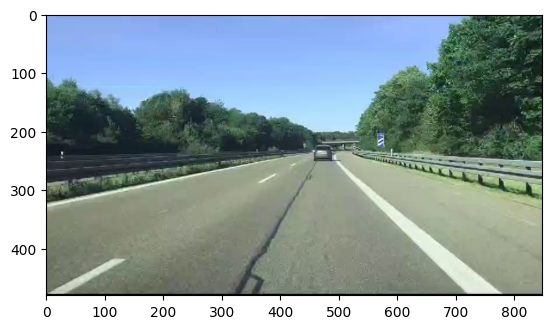

In [7]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

# **2. DATA LOAING**

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, label_mode='categorical',batch_size = 64)

Found 2287 files belonging to 3 classes.


In [7]:
data_iterator = dataset.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

In [9]:
len(batch)

2

* [1,0,0] for broken lanes
* [0,1,0] for yellow lanes
* [0,0,1] for solid lanes

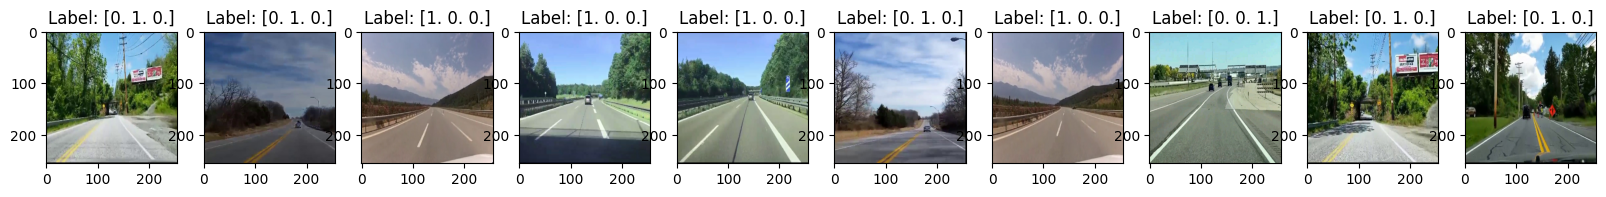

In [12]:
fig, ax = plt.subplots(ncols=10, figsize = (20,20))
for idx, img in enumerate (batch[0][:10]):
  ax[idx].imshow(img.astype(int))
  ax[idx].set_title(f'Label: {batch[1][idx]}')

In [10]:
batch[0].shape

(64, 256, 256, 3)

In [11]:
import tensorflow as tf

def resize_function(x, y):
    resized_x = tf.image.resize(x, (80, 160))

    return resized_x, y

# Apply the resize function to each element in the dataset
dataset = dataset.map(resize_function)

dataset = dataset.map(lambda x,y : (x/255,y))

In [12]:
scaled_iterator = dataset.as_numpy_iterator()

In [13]:
scaled_batch = scaled_iterator.next()

In [14]:
scaled_batch[0].max()

1.0

In [15]:
scaled_batch[0].shape

(64, 80, 160, 3)

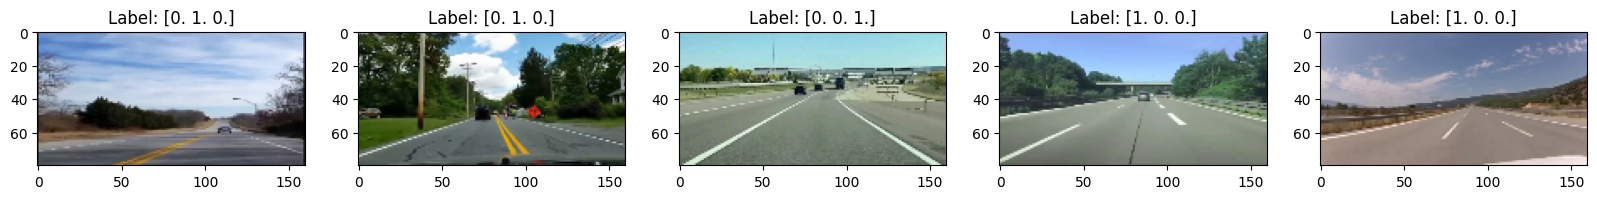

In [19]:
fig, ax = plt.subplots(ncols=5, figsize = (20,20))
for idx, img in enumerate (scaled_batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].set_title(f'Label: {scaled_batch[1][idx]}')

In [16]:
len(dataset)

36

In [17]:
train_size = int(len(dataset)*.7)+1
val_size = int(len(dataset)*.1)+2
test_size = int(len(dataset)*.1)+2

In [18]:
test_size+train_size+val_size

36

In [19]:
train_size

26

In [20]:
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size).take(val_size)
test_data = dataset.skip(train_size+val_size).take(test_size)

In [21]:
def extract_features_labels(image, label):
    return image, label

x_train, y_train = zip(*train_data.map(extract_features_labels))
x_val, y_val = zip(*val_data.map(extract_features_labels))
x_test, y_test = zip(*test_data.map(extract_features_labels))

In [22]:
x_train = tf.concat(x_train, axis=0).numpy()
y_train = tf.concat(y_train, axis=0).numpy()
x_val = tf.concat(x_val, axis=0).numpy()
y_val = tf.concat(y_val, axis=0).numpy()
x_test = tf.concat(x_test, axis=0).numpy()
y_test = tf.concat(y_test, axis=0).numpy()

In [23]:
print(y_train.shape)
print(x_train.shape)
print(y_val.shape)
print(x_val.shape)
print(y_test.shape)
print(x_test.shape)

(1664, 3)
(1664, 80, 160, 3)
(320, 3)
(320, 80, 160, 3)
(303, 3)
(303, 80, 160, 3)


# **3. VGG-16**

In [28]:
#importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


In [43]:
# vgg16 architecture
vgg16_model = VGG16(weights='imagenet',
                    include_top=False,
                    classes=3,
                    input_shape=(80,160,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

58889256/58889256 [==============================] - 4s 0us/step


In [44]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)


In [45]:
# adding extra layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 80, 160, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 160, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 40, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 20, 40, 256)       2

In [46]:
# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= 'adam',metrics=['accuracy'])

In [29]:
# data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [48]:
log_dir = ("/content/sample_data/MyDrive/MyDrive/lane_classifier/logs")

In [49]:
callbacks = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [50]:
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


In [51]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 64

history = model.fit(
    aug.flow(x_train,y_train, batch_size=BS),
    validation_data=(x_val,y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=[callbacks])

Epoch 1/30
26/26 [==============================] - 37s 520ms/step - loss: 1.2261 - accuracy: 0.3942 - val_loss: 1.0766 - val_accuracy: 0.4719
Epoch 2/30
26/26 [==============================] - 9s 342ms/step - loss: 1.0686 - accuracy: 0.4495 - val_loss: 1.0488 - val_accuracy: 0.4719
Epoch 3/30
26/26 [==============================] - 9s 339ms/step - loss: 1.0748 - accuracy: 0.4291 - val_loss: 0.9968 - val_accuracy: 0.4719
Epoch 4/30
26/26 [==============================] - 8s 287ms/step - loss: 0.9753 - accuracy: 0.4525 - val_loss: 0.7961 - val_accuracy: 0.4719
Epoch 5/30
26/26 [==============================] - 10s 369ms/step - loss: 0.7823 - accuracy: 0.6647 - val_loss: 0.4687 - val_accuracy: 0.9563
Epoch 6/30
26/26 [==============================] - 10s 390ms/step - loss: 0.5331 - accuracy: 0.8293 - val_loss: 0.5885 - val_accuracy: 0.8344
Epoch 7/30
26/26 [==============================] - 8s 298ms/step - loss: 0.4780 - accuracy: 0.8413 - val_loss: 0.2697 - val_accuracy: 0.9156
Epo

**EVALUATION**

In [52]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [53]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [54]:
for batch in test_data.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  precision.update_state(y,yhat)
  recall.update_state(y,yhat)
  accuracy.update_state(y,yhat)

2/2 [==============================] - 2s 2s/step


In [55]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))

Precision: 1.0 
Recall: 1.0 
Accuracy: 1.0 


In [56]:
yhat = model.predict(x_test)
precision.update_state(y_test,yhat)
recall.update_state(y_test,yhat)
accuracy.update_state(y_test,yhat)

10/10 [==============================] - 0s 43ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=606.0>

In [57]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))

Precision: 1.0 
Recall: 1.0 
Accuracy: 1.0 


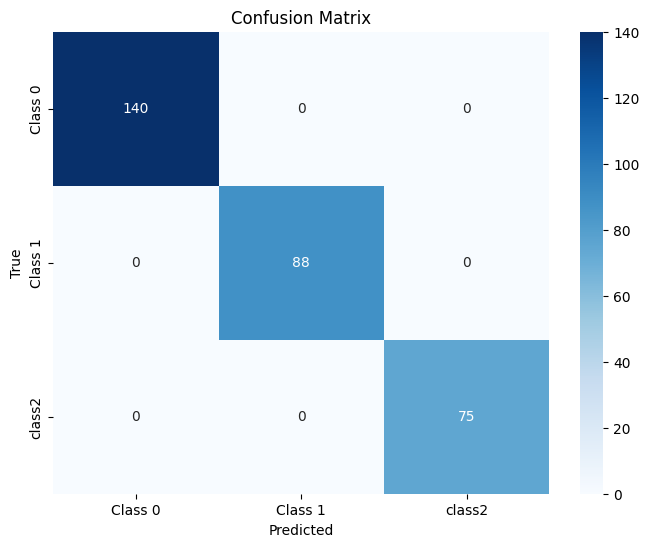

In [58]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(yhat, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'class2'], yticklabels=['Class 0', 'Class 1', 'class2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:
test_dir = "/content/sample_data/MyDrive/MyDrive/lane_classifier/test"

In [60]:
def Prediction (predictions):
    if np.array_equal(predictions, np.array([[0, 1, 0]])):
        return "Double Solid Yellow Lane"
    elif np.array_equal(predictions, np.array([[1, 0, 0]])):
        return "Dashed White Lane"
    elif np.array_equal(predictions, np.array([[0, 0, 1]])):
        return "solid white lane"
    else:
        return "Unidentified"

1/1 [==============================] - 0s 41ms/step
Dashed White Lane


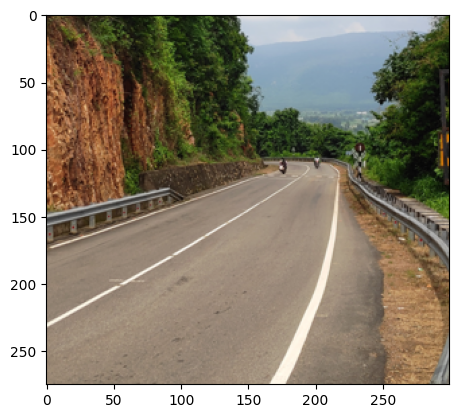

In [64]:
test_7 = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_classifier/testing/solid_white3.png")
resize = tf.image.resize(test_7, (80,160))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 62ms/step
solid white lane


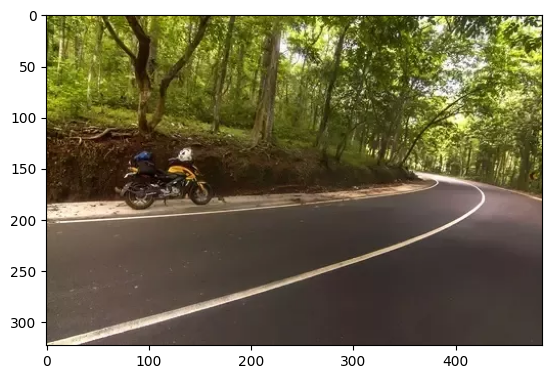

In [65]:
test_7 = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_classifier/testing/solid_white4.png")
resize = tf.image.resize(test_7, (80,160))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 31ms/step
Dashed White Lane


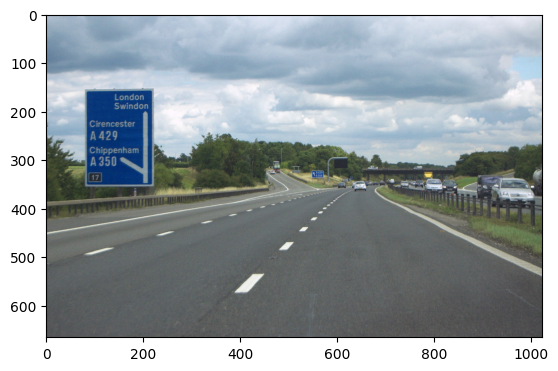

In [66]:
test_7 = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_classifier/testing/brokken_lane.jpg")
resize = tf.image.resize(test_7, (80,160))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

In [68]:
model_dir = ("/content/sample_data/MyDrive/MyDrive/lane_classifier/model")

In [69]:
model.save(os.path.join(model_dir, 'lane_classifier_VGG16_80X160.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
os.listdir(model_dir)

['laneClassifier.h5',
 'lane_classifier.h5',
 'lane_classifier_VGG16.h5',
 'lane_classifier_VGG16_80X160.h5']

# **4. RES-NET**

In [24]:
# RESNET Architecture
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(80, 160, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [25]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 160, 3)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 86, 166, 3)           0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 40, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 40, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [26]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [35]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)


In [30]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 64

history = model.fit(
    aug.flow(x_train,y_train, batch_size=BS),
    validation_data=(x_val,y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS)

Epoch 1/30
26/26 [==============================] - 17s 347ms/step - loss: 1.0325 - accuracy: 0.4561 - val_loss: 0.9404 - val_accuracy: 0.6781
Epoch 2/30
26/26 [==============================] - 7s 263ms/step - loss: 0.9338 - accuracy: 0.5637 - val_loss: 0.7797 - val_accuracy: 0.7188
Epoch 3/30
26/26 [==============================] - 7s 287ms/step - loss: 0.8254 - accuracy: 0.6388 - val_loss: 0.5551 - val_accuracy: 0.8406
Epoch 4/30
26/26 [==============================] - 7s 257ms/step - loss: 0.7428 - accuracy: 0.6941 - val_loss: 0.5484 - val_accuracy: 0.8125
Epoch 5/30
26/26 [==============================] - 6s 246ms/step - loss: 0.6611 - accuracy: 0.7386 - val_loss: 0.6239 - val_accuracy: 0.7719
Epoch 6/30
26/26 [==============================] - 6s 242ms/step - loss: 0.6041 - accuracy: 0.7746 - val_loss: 0.3589 - val_accuracy: 0.8813
Epoch 7/30
26/26 [==============================] - 8s 294ms/step - loss: 0.6113 - accuracy: 0.7416 - val_loss: 0.4618 - val_accuracy: 0.8313
Epoch

In [31]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [32]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [33]:
yhat = model.predict(x_test)
precision.update_state(y_test,yhat)
recall.update_state(y_test,yhat)
accuracy.update_state(y_test,yhat)

10/10 [==============================] - 2s 133ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=303.0>

In [34]:
print("Precision: {} " .format(precision.result()))
print("Recall: {} " .format(recall.result()))
print("Accuracy: {} " .format(accuracy.result()))

Precision: 0.9006622433662415 
Recall: 0.8976897597312927 
Accuracy: 0.8976897597312927 


In [35]:
def Prediction (predictions):
    if np.array_equal(predictions, np.array([[0, 1, 0]])):
        return "Double Solid Yellow Lane"
    elif np.array_equal(predictions, np.array([[1, 0, 0]])):
        return "Dashed White Lane"
    elif np.array_equal(predictions, np.array([[0, 0, 1]])):
        return "solid white lane"
    else:
        return "Unidentified"

1/1 [==============================] - 1s 882ms/step
Double Solid Yellow Lane


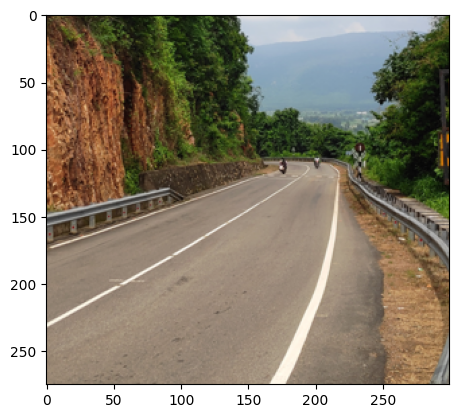

In [36]:
test_7 = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_classifier/testing/solid_white3.png")
resize = tf.image.resize(test_7, (80,160))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 23ms/step
Dashed White Lane


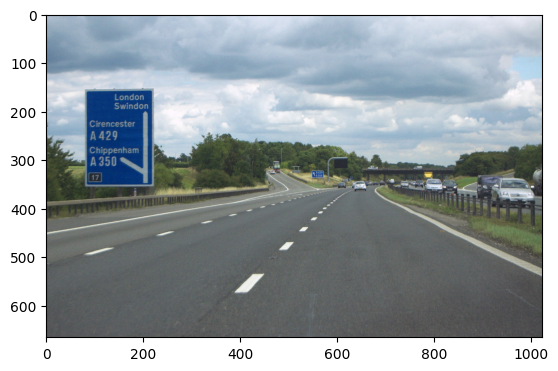

In [37]:
test_7 = cv2.imread("/content/sample_data/MyDrive/MyDrive/lane_classifier/testing/brokken_lane.jpg")
resize = tf.image.resize(test_7, (80,160))
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.round(yhat)
print(Prediction(yhat))
plt.imshow(cv2.cvtColor(test_7, cv2.COLOR_BGR2RGB))

In [42]:
model_dir = ("/content/sample_data/MyDrive/MyDrive/lane_classifier/model")

In [43]:
model.save(os.path.join(model_dir, 'lane_classifier_RES-NET_80X160.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
os.listdir(model_dir)

['laneClassifier.h5',
 'lane_classifier.h5',
 'lane_classifier_VGG16.h5',
 'lane_classifier_VGG16_80X160.h5',
 'lane_classifier_RES-NET_80X160.h5']